In [1]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras import backend as Keras

Using TensorFlow backend.


### Mine Triplets

In [2]:
CAFFE_ROOT = '/home/albert/caffe/'
img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')

In [3]:
train_files = {}
train_arr = []
labels = []

for f in img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in labels):
            labels.append(idt)
            train_files[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files[idt].append(path)
        train_arr.append([path, idt])

labels.sort()

In [4]:
def batch_generator(train_files, labels, P=18, K=4):
    while True:
        batch = []
        idt_choice = np.random.choice(labels, P, replace=False)
        for p in range(len(idt_choice)):
#             batch.append([])
            k_choice = np.random.choice(range(len(train_files[idt_choice[p]])), K, replace=True)
            for k in k_choice:
                path = train_files[idt_choice[p]][k]
                img = cv2.resize(misc.imread(path), (224, 224))
                batch.append(img.tolist())
        yield(batch)

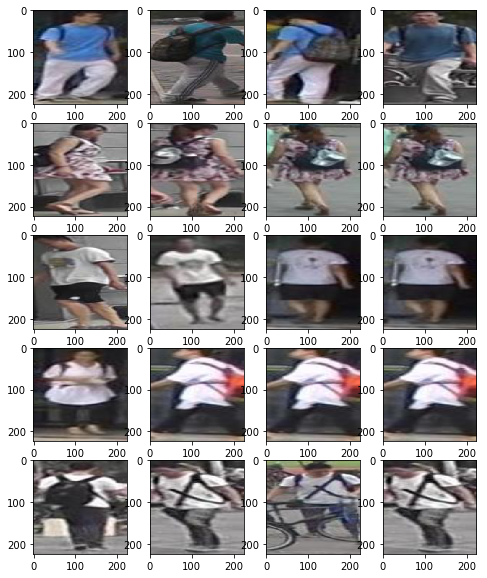

In [5]:
generator = batch_generator(train_files, labels)
batch = generator.next()
batch = np.array(batch, dtype=np.uint8)

plt.figure(figsize=(8,10))
t = 0
for idt in range(20):
    t += 1
    plt.subplot(5, 4, t)
    plt.imshow(batch[idt])
plt.show()

### Train Network

In [6]:
model = ResNet50(weights='imagenet', include_top=False)

In [7]:
def output_batch_generator(train_files, labels, P=18, K=4):
    while True:
        batch = []
        idt_choice = np.random.choice(labels, P, replace=False)
        for p in range(len(idt_choice)):
            # n_choose = np.minimum(K, len(train_files[idt_choice[p]]))
            k_choice = np.random.choice(range(len(train_files[idt_choice[p]])), K, replace=True)
            for k in k_choice:
                path = train_files[idt_choice[p]][k]
                img = cv2.resize(misc.imread(path), (224, 224))
                batch.append(img.tolist())
        output = model.predict_on_batch(batch)
        yield(output, np.zeros((output.shape[0], output.shape[1], output.shape[2], 1)))

In [8]:
output_generator = output_batch_generator(train_files, labels)

In [9]:
output_batch = output_generator.next()

In [10]:
print(output_batch[0].shape)

(72, 1, 1, 2048)


In [11]:
def log1p(x):
    return Keras.log(1 + Keras.exp(x))

In [12]:
def dist(x1, x2):
    return Keras.sum(Keras.abs(x1 - x2))

In [13]:
def triplet_loss(y_true, y_pred, margin=0.1, P=18, K=4, output_dim = 128):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))

    loss = tf.Variable(1, dtype=tf.float32)

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                      embeddings[(i + 1)*K:]], 0)))
            loss += margin + hard_pos - hard_neg
    return loss

In [14]:
def evaluate_rank(net, rank, all_embeddings, all_identities, test_iter=1000):
    correct = 0
    f_choice = np.random.choice(range(len(train_arr)), np.minimum(test_iter, len(train_arr)), replace=False)
    for f in f_choice:
        query_img = cv2.resize(misc.imread(train_arr[f][0]), (224,224))
        query_embedding = net.predict(model.predict(query_img.reshape(1, 224, 224, 3)))
        distance_vectors = np.squeeze(np.abs(all_embeddings - query_embedding))
        distance = np.sum(distance_vectors, axis=1)
        top_inds = distance.argsort()[:20]
        output_classes = np.array(all_identities)[top_inds].astype(np.uint16)
        
#         pp.pprint(zip(distance[top_inds], np.array(all_identities)[top_inds].astype(np.uint16)))
        
        i = 0
        for c in output_classes:
            if c == int(train_arr[f][1]):
                i += 1
        if i > 1:
            correct += 1
#         print(correct)
    return float(correct)/test_iter

In [15]:
score_arr = []

In [18]:
i = 0
for epochs in range(20, 100, 10):
    trinet = Sequential()
    trinet.add(Dense(1024, input_shape=(1, 1, 2048)))
    trinet.add(BatchNormalization())
    trinet.add(Activation('relu'))
    trinet.add(Dense(128))

    trinet.compile(loss=triplet_loss, optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))
    trinet.fit_generator(output_batch_generator(train_files, labels), steps_per_epoch=5, epochs=epochs)

    trinet.save('/home/albert/github/tensorflow/trinet_epochs_%d.h5' % epochs)

    all_embeddings = []
    all_identities = []
    for idt in train_files.keys():
        for f in train_files[idt]:
            img = cv2.resize(misc.imread(f), (224,224))
            predict_resnet = model.predict(img.reshape(1, 224, 224, 3))
            predict_trinet = trinet.predict(predict_resnet)
            all_embeddings.append(predict_trinet)
            all_identities.append(idt)
    
    score_arr.append([])
    for x in range(3):
        score = evaluate_rank(trinet, 20, all_embeddings, all_identities, test_iter=1000)
        score_arr[i].append(score)
    i += 1

Epoch 1/20
5/5 [==============================] - 18s - loss: -605952.0250    
Epoch 2/20
5/5 [==============================] - 17s - loss: -855604.7875    
Epoch 3/20
5/5 [==============================] - 17s - loss: -1169763.4000    
Epoch 4/20
5/5 [==============================] - 17s - loss: -1494339.1750    
Epoch 5/20
5/5 [==============================] - 18s - loss: -1863377.5250    
Epoch 6/20
5/5 [==============================] - 17s - loss: -2279962.2000    
Epoch 7/20
5/5 [==============================] - 18s - loss: -2767880.3500    
Epoch 8/20
5/5 [==============================] - 17s - loss: -3239582.4500    
Epoch 9/20
5/5 [==============================] - 17s - loss: -3894644.7000    
Epoch 10/20
5/5 [==============================] - 17s - loss: -4589717.7000    
Epoch 11/20
5/5 [==============================] - 18s - loss: -5278560.6000    
Epoch 12/20
5/5 [==============================] - 17s - loss: -6078608.1000    
Epoch 13/20
5/5 [======================

5/5 [==============================] - 19s - loss: -6193680.8000    
Epoch 13/50
5/5 [==============================] - 18s - loss: -6992515.5000    
Epoch 14/50
5/5 [==============================] - 19s - loss: -7704669.2000    
Epoch 15/50
5/5 [==============================] - 19s - loss: -8722484.8000    
Epoch 16/50
5/5 [==============================] - 19s - loss: -9633806.0000    
Epoch 17/50
5/5 [==============================] - 18s - loss: -10518776.6000    
Epoch 18/50
5/5 [==============================] - 19s - loss: -11239495.4000    
Epoch 19/50
5/5 [==============================] - 19s - loss: -12323016.0000    
Epoch 20/50
5/5 [==============================] - 18s - loss: -13207521.4000    
Epoch 21/50
5/5 [==============================] - 19s - loss: -13921655.0000    
Epoch 22/50
5/5 [==============================] - 19s - loss: -15052008.4000    
Epoch 23/50
5/5 [==============================] - 18s - loss: -15853037.2000    
Epoch 24/50
5/5 [================

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.482846). Check your callbacks.
  % delta_t_median)


5/5 [==============================] - 19s - loss: -5576804.7000    
Epoch 12/60
5/5 [==============================] - 19s - loss: -6364260.5000    
Epoch 13/60
5/5 [==============================] - 20s - loss: -7199732.8000    
Epoch 14/60
5/5 [==============================] - 19s - loss: -8167308.8000    
Epoch 15/60
1/5 [=====>........................] - ETA: 10s - loss: -8589449.0000

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.952599). Check your callbacks.
  % delta_t_median)


2/5 [===========>..................] - ETA: 11s - loss: -8690373.5000

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.485968). Check your callbacks.
  % delta_t_median)


5/5 [==============================] - 19s - loss: -8830692.4000    
Epoch 16/60
5/5 [==============================] - 19s - loss: -9828025.6000    
Epoch 17/60
5/5 [==============================] - 20s - loss: -10718067.4000    
Epoch 18/60
5/5 [==============================] - 19s - loss: -11640755.6000    
Epoch 19/60
5/5 [==============================] - 19s - loss: -12400974.8000    
Epoch 20/60
5/5 [==============================] - 19s - loss: -13307446.2000    
Epoch 21/60
5/5 [==============================] - 20s - loss: -14544657.0000    
Epoch 22/60
5/5 [==============================] - 19s - loss: -15221467.2000    
Epoch 23/60
5/5 [==============================] - 19s - loss: -16041909.8000    
Epoch 24/60
5/5 [==============================] - 19s - loss: -17183264.0000    
Epoch 25/60
5/5 [==============================] - 18s - loss: -17970144.0000    
Epoch 26/60
5/5 [==============================] - 19s - loss: -18814229.2000    
Epoch 27/60
5/5 [=============

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.529649). Check your callbacks.
  % delta_t_median)


5/5 [==============================] - 19s - loss: -5945402.1000    
Epoch 13/70
5/5 [==============================] - 20s - loss: -6766062.0000    
Epoch 14/70
5/5 [==============================] - 18s - loss: -7722062.3000    
Epoch 15/70
5/5 [==============================] - 19s - loss: -8465735.3000    
Epoch 16/70
5/5 [==============================] - 20s - loss: -9377985.2000    
Epoch 17/70
5/5 [==============================] - 19s - loss: -10277973.6000    
Epoch 18/70
5/5 [==============================] - 18s - loss: -11145489.0000    
Epoch 19/70
5/5 [==============================] - 20s - loss: -12139023.4000    
Epoch 20/70
5/5 [==============================] - 19s - loss: -13166252.0000    
Epoch 21/70
5/5 [==============================] - 19s - loss: -13961468.0000    
Epoch 22/70
5/5 [==============================] - 19s - loss: -14899864.4000    
Epoch 23/70
5/5 [==============================] - 18s - loss: -15830142.8000    
Epoch 24/70
5/5 [================

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.527883). Check your callbacks.
  % delta_t_median)


5/5 [==============================] - 19s - loss: -28736184.4000    
Epoch 38/70
5/5 [==============================] - 20s - loss: -29793318.0000    
Epoch 39/70
5/5 [==============================] - 18s - loss: -30861348.0000    
Epoch 40/70
5/5 [==============================] - 20s - loss: -31660099.2000    
Epoch 41/70
5/5 [==============================] - 19s - loss: -32791622.4000    
Epoch 42/70
5/5 [==============================] - 18s - loss: -34027249.6000    
Epoch 43/70
5/5 [==============================] - 18s - loss: -34240195.2000    
Epoch 44/70
5/5 [==============================] - 20s - loss: -35127012.0000    
Epoch 45/70
5/5 [==============================] - 19s - loss: -36743456.8000    
Epoch 46/70
5/5 [==============================] - 18s - loss: -37650060.8000    
Epoch 47/70
5/5 [==============================] - 20s - loss: -38014940.0000    
Epoch 48/70
5/5 [==============================] - 19s - loss: -39443917.6000    
Epoch 49/70
5/5 [===========

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.087307). Check your callbacks.
  % delta_t_median)


2/5 [===========>..................] - ETA: 12s - loss: -52576002.0000

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.544020). Check your callbacks.
  % delta_t_median)


5/5 [==============================] - 18s - loss: -52662096.0000    
Epoch 61/80
5/5 [==============================] - 19s - loss: -52723816.0000    
Epoch 62/80
5/5 [==============================] - 21s - loss: -52790220.8000    
Epoch 63/80
5/5 [==============================] - 19s - loss: -54514442.4000    
Epoch 64/80
5/5 [==============================] - 19s - loss: -55610757.6000    
Epoch 65/80
5/5 [==============================] - 21s - loss: -56961002.4000    
Epoch 66/80
5/5 [==============================] - 20s - loss: -58110548.8000    
Epoch 67/80
5/5 [==============================] - 18s - loss: -59192631.2000    
Epoch 68/80
5/5 [==============================] - 21s - loss: -59463780.8000    
Epoch 69/80
5/5 [==============================] - 20s - loss: -61722343.2000    
Epoch 70/80
5/5 [==============================] - 19s - loss: -62568703.2000    
Epoch 71/80
5/5 [==============================] - 21s - loss: -63476457.6000    
Epoch 72/80
5/5 [===========

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.210881). Check your callbacks.
  % delta_t_median)


2/5 [===========>..................] - ETA: 14s - loss: -3932532.3750

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.605957). Check your callbacks.
  % delta_t_median)


5/5 [==============================] - 20s - loss: -4180751.6500    
Epoch 10/90
5/5 [==============================] - 20s - loss: -4907405.4000    
Epoch 11/90
5/5 [==============================] - 20s - loss: -5608600.9000    
Epoch 12/90
5/5 [==============================] - 22s - loss: -6471748.2000    
Epoch 13/90
5/5 [==============================] - 19s - loss: -7285000.5000    
Epoch 14/90
5/5 [==============================] - 20s - loss: -8161828.0000    
Epoch 15/90
1/5 [=====>........................] - ETA: 16s - loss: -8700449.0000

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.187093). Check your callbacks.
  % delta_t_median)


2/5 [===========>..................] - ETA: 14s - loss: -8794909.0000

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.612976). Check your callbacks.
  % delta_t_median)


4/5 [=======================>......] - ETA: 4s - loss: -8951796.5000

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.611725). Check your callbacks.
  % delta_t_median)


5/5 [==============================] - 21s - loss: -9079853.8000    
Epoch 16/90
5/5 [==============================] - 20s - loss: -9873378.8000    
Epoch 17/90
5/5 [==============================] - 19s - loss: -10949408.2000    
Epoch 18/90
5/5 [==============================] - 21s - loss: -11569906.8000    
Epoch 19/90
5/5 [==============================] - 19s - loss: -12858604.6000    
Epoch 20/90
5/5 [==============================] - 19s - loss: -13328989.0000    
Epoch 21/90
5/5 [==============================] - 20s - loss: -14419563.4000    
Epoch 22/90
5/5 [==============================] - 20s - loss: -15284985.0000    
Epoch 23/90
5/5 [==============================] - 20s - loss: -16208222.2000    
Epoch 24/90
5/5 [==============================] - 22s - loss: -17115828.8000    
Epoch 25/90
5/5 [==============================] - 19s - loss: -17926866.8000    
Epoch 26/90
5/5 [==============================] - 20s - loss: -19041896.8000    
Epoch 27/90
5/5 [=============

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.199210). Check your callbacks.
  % delta_t_median)


2/5 [===========>..................] - ETA: 14s - loss: -60287900.0000

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.599972). Check your callbacks.
  % delta_t_median)


5/5 [==============================] - 20s - loss: -60529086.4000    
Epoch 70/90
5/5 [==============================] - 20s - loss: -63021430.4000    
Epoch 71/90
5/5 [==============================] - 20s - loss: -62930175.2000    
Epoch 72/90
5/5 [==============================] - 22s - loss: -64730884.8000    
Epoch 73/90
5/5 [==============================] - 20s - loss: -65871613.6000    
Epoch 74/90
5/5 [==============================] - 19s - loss: -66972569.6000    
Epoch 75/90
5/5 [==============================] - 22s - loss: -66972303.2000    
Epoch 76/90
2/5 [===========>..................] - ETA: 10s - loss: -69317560.0000

/home/albert/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.616365). Check your callbacks.
  % delta_t_median)


5/5 [==============================] - 20s - loss: -69374288.0000    
Epoch 77/90
5/5 [==============================] - 19s - loss: -69801534.4000    
Epoch 78/90
5/5 [==============================] - 21s - loss: -71227115.2000    
Epoch 79/90
5/5 [==============================] - 19s - loss: -73589579.2000    
Epoch 80/90
5/5 [==============================] - 20s - loss: -73651019.2000    
Epoch 81/90
5/5 [==============================] - 20s - loss: -74580809.6000    
Epoch 82/90
5/5 [==============================] - 20s - loss: -75150160.0000    
Epoch 83/90
5/5 [==============================] - 19s - loss: -76579059.2000    
Epoch 84/90
5/5 [==============================] - 21s - loss: -78898204.8000    
Epoch 85/90
5/5 [==============================] - 20s - loss: -80172843.2000    
Epoch 86/90
5/5 [==============================] - 19s - loss: -81865187.2000    
Epoch 87/90
5/5 [==============================] - 21s - loss: -83231932.8000    
Epoch 88/90
5/5 [===========

In [19]:
np.save('/home/albert/github/tensorflow/rank20.npy', np.array(score_arr))

In [20]:
print score_arr

[[0.08, 0.072, 0.089, 0.089], [0.053, 0.06, 0.041], [0.046, 0.042, 0.052], [0.049, 0.055, 0.055], [0.043, 0.048, 0.041], [0.035, 0.043, 0.049], [0.054, 0.04, 0.045], [0.05, 0.044, 0.049], []]


https://keras.io/getting-started/faq/: use load_model to reinstantiate model.

### Evaluate Performance

In [71]:
p = 7
query_img = cv2.resize(misc.imread(train_files[p][2]), (224,224))
query_embedding = trinet.predict(model.predict(query_img.reshape(1, 224, 224, 3)))

In [72]:
distance_vectors = np.squeeze(np.abs(all_embeddings - query_embedding))
distance = np.sum(distance_vectors, axis=1)

In [73]:
top_inds = distance.argsort()[:20]
output_classes = np.array(all_identities)[top_inds]
pp.pprint(zip(distance[top_inds], np.array(all_identities)[top_inds].astype(np.uint16)))

[(0.0, 7),
 (87.264503, 820),
 (87.559258, 22),
 (87.703964, 840),
 (88.146141, 709),
 (92.812653, 162),
 (94.948166, 826),
 (96.821381, 7),
 (97.317627, 88),
 (97.703339, 1400),
 (99.084099, 986),
 (99.157936, 1258),
 (99.706284, 709),
 (100.31776, 273),
 (100.34363, 972),
 (100.4324, 919),
 (100.79021, 272),
 (101.04869, 685),
 (102.47899, 876),
 (102.48692, 1343)]
